In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/DoHieuNghia/belief-merging/data/'

categories = ['banh-hoi-heo-quay', 'bun-bo-hue', 'bun-ca', 'bun-dau-mam-tom', 'bun-hai-san-be-be', 'bun-moc', 'bun-muc', 'bun-nuoc-leo',
              'cao-lau', 'com-ga', 'com-tam-long-xuyen', 'hu-tieu-my-tho', 'mi-quang', 'pho-ha-noi']

In [4]:
data = []
labels = []
imagePaths = []
HEIGHT = 224
WIDTH = 224
N_CHANNELS = 3

for k, category in enumerate(categories):
    for f in os.listdir(path+category):
        imagePaths.append([path+category+'/'+f, k])

In [5]:
import random
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
imagePaths

In [ ]:
for id, imagePath in enumerate(imagePaths):
    print(id)
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (WIDTH, HEIGHT))
    data.append(image)
    label = imagePath[1]
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, len(categories))

In [8]:
trainX.shape

(1518, 224, 224, 3)

In [9]:
from keras.applications import InceptionV3

EPOCHS = 10
INIT_LR = 0.001
BS = 16

class_names = categories

base_model = InceptionV3(input_shape=(WIDTH, HEIGHT, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(len(class_names), activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                                 
Total params: 21831470 (83.28 MB)
Trainable params: 28686 (112.05 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [10]:
model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/10
95/95 [==============================] - 192s 2s/step - loss: 2.5833 - accuracy: 0.2246
Epoch 2/10
95/95 [==============================] - 198s 2s/step - loss: 1.7160 - accuracy: 0.4354
Epoch 3/10
95/95 [==============================] - 187s 2s/step - loss: 1.4181 - accuracy: 0.5296
Epoch 4/10
95/95 [==============================] - 188s 2s/step - loss: 1.2539 - accuracy: 0.5949
Epoch 5/10
95/95 [==============================] - 196s 2s/step - loss: 1.1671 - accuracy: 0.6034
Epoch 6/10
95/95 [==============================] - 207s 2s/step - loss: 1.0209 - accuracy: 0.6482
Epoch 7/10
95/95 [==============================] - 196s 2s/step - loss: 0.9142 - accuracy: 0.6950
Epoch 8/10
95/95 [==============================] - 192s 2s/step - loss: 0.8621 - accuracy: 0.7141
Epoch 9/10
95/95 [==============================] - 193s 2s/step - loss: 0.8619 - accuracy: 0.7101
Epoch 10/10
95/95 [==============================] - 191s 2s/step - loss: 0.7109 - accuracy: 0.7582


In [14]:
model.save("/content/drive/MyDrive/DoHieuNghia/belief-merging/models/inceptionv3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 74s 6s/step


<ipython-input-11-161b651fd219>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories)
<ipython-input-11-161b651fd219>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories)


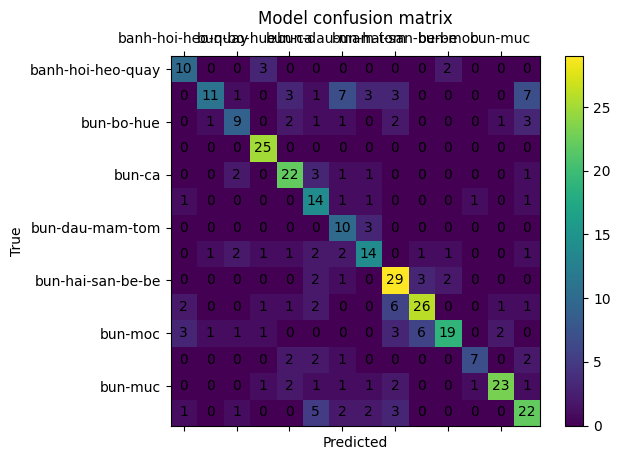

In [11]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

pred = model.predict(testX)
predictions = argmax(pred, axis=1) # return to label

cm = confusion_matrix(testY, predictions)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + categories)
ax.set_yticklabels([''] + categories)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
accuracy = accuracy_score(testY, predictions)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

recall= recall_score(testY, predictions,average='weighted')
print("Recall :%.2f%%" % (recall*100))
print("\n")

precision = precision_score(testY, predictions,average='weighted')
print("Precision : %.2f%%" % (precision*100.0))
print("\n")

f1 = f1_score(testY, predictions,average='weighted')
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

Accuracy : 63.42%


Recall :63.42%


Precision : 66.94%


F1 : 63.02%




In [13]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Make predictions on the training data
train_pred = model.predict(trainX)
train_predictions = argmax(train_pred, axis=1)

# Make predictions on the test data
test_pred = model.predict(testX)
test_predictions = argmax(test_pred, axis=1)

# Combine train and test predictions
all_predictions = np.concatenate((train_predictions, test_predictions), axis=0)
all_labels = np.concatenate((trainY.argmax(axis=1), testY), axis=0)

# Evaluate on the whole dataset
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy on the whole dataset: %.2f%%" % (accuracy * 100.0))
print("\n")

recall = recall_score(all_labels, all_predictions, average='weighted')
print("Recall on the whole dataset: %.2f%%" % (recall * 100))
print("\n")

precision = precision_score(all_labels, all_predictions, average='weighted')
print("Precision on the whole dataset: %.2f%%" % (precision * 100.0))
print("\n")

f1 = f1_score(all_labels, all_predictions, average='weighted')
print("F1 score on the whole dataset: %.2f%%" % (f1 * 100.0))
print("\n")

12/12 [==============================] - 51s 4s/step
Accuracy on the whole dataset: 83.72%


Recall on the whole dataset: 83.72%


Precision on the whole dataset: 84.83%


F1 score on the whole dataset: 83.65%




In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import random

# Path to the original dataset
original_dataset_path = '/content/drive/MyDrive/DoHieuNghia/belief-merging/data/'

# Path to save the new test dataset
new_test_dataset_path = '/content/drive/MyDrive/DoHieuNghia/belief-merging/data_test/'

# Categories
categories = ['banh-hoi-heo-quay', 'bun-bo-hue', 'bun-ca', 'bun-dau-mam-tom', 'bun-hai-san-be-be', 'bun-moc', 'bun-muc', 'bun-nuoc-leo',
              'cao-lau', 'com-ga', 'com-tam-long-xuyen', 'hu-tieu-my-tho', 'mi-quang', 'pho-ha-noi']

# List to hold image paths and labels
imagePaths = []

# Read images and labels
for k, category in enumerate(categories):
    for f in os.listdir(original_dataset_path + category):
        imagePaths.append([original_dataset_path + category + '/' + f, k])

# Shuffle the data
random.seed(42)
random.shuffle(imagePaths)

# Split the data into train and test sets
trainPaths, testPaths = train_test_split(imagePaths, test_size=0.2, random_state=42)

# Create new test dataset directory if it doesn't exist
if not os.path.exists(new_test_dataset_path):
    os.makedirs(new_test_dataset_path)

# Create subdirectories for each category in the test dataset
for category in categories:
    category_path = os.path.join(new_test_dataset_path, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)

# Copy the test images to the new dataset directory
for testPath in testPaths:
    src = testPath[0]
    category_index = testPath[1]
    category_name = categories[category_index]
    dst = os.path.join(new_test_dataset_path, category_name, os.path.basename(src))
    shutil.copyfile(src, dst)

print("Test dataset has been saved successfully.")


Test dataset has been saved successfully.


In [ ]:
new_train_dataset_path = '/content/drive/MyDrive/DoHieuNghia/belief-merging/data_train/'

# Create new train dataset directory if it doesn't exist
if not os.path.exists(new_train_dataset_path):
    os.makedirs(new_train_dataset_path)

# Create subdirectories for each category in the train dataset
for category in categories:
    category_path = os.path.join(new_train_dataset_path, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)

# Copy the train images to the new dataset directory
for trainPath in trainPaths:
    src = trainPath[0]
    category_index = trainPath[1]
    category_name = categories[category_index]
    dst = os.path.join(new_train_dataset_path, category_name, os.path.basename(src))
    shutil.copyfile(src, dst)

print("train dataset has been saved successfully.")

train dataset has been saved successfully.
